In [19]:
%matplotlib inline
import local_broom

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qcodes import Station, Instrument
from scipy.signal import find_peaks
from tqdm import tqdm

from monty import Monty
from liveplot import LivePlot, LiveContourPlot
import feedback
import swiper
import MDAC
from fridge import Fridge

# Import the neighbouring files. In may/
import may.dots as dots
from may.custom_devices import connect_to_gb, newSiDot

In [3]:
#%% Connect to instruments

# close any open instruments 
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')
    
try:
    lockin = Instrument.find_instrument("sr860_top")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name sr860_top. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')
lockin = scfg.load_instrument('sr860_top')

# Create our custom MDAC mappings
gb_control_si = connect_to_gb(mdac)
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist
Cannot remove instrument with name sr860_top. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.23s
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.12s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [309]:
experiment = {
    "desc": "Recover and find the regime again. Perform a very large automated parameter sweep"
}

monty = Monty("dc.power recovery", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 71


In [14]:
si.ST()
si.SRB(0.95)
si.SLB(0.95)
si.P1(1.9)
si.P2(1.9)
si.ST(3.3)
si.LCB(0.15)
si.RCB(0.15)

In [310]:
dots.get_all_voltages(mdac)

LCB:   0.150004 V
RCB:   0.150003 V
RG:    0.0 V
ResB:  0.0 V
P3:    0.0 V
P2:    1.6 V
P1:    1.969629 V
SETB:  0.0 V
SRB:   0.929996 V
SLB:   0.930001 V
ST:    3.508183 V
bias:  0.0 V
VSS1P8:      0.0 V
VSS1P0:      0.0 V
VDD1P8:      1.800005 V
VDD1P0:      0.999996 V
VDD1P8_ANA:  1.8 V
BGN1P0:      0.0 V
BGN1P8:      0.0 V
BGP1P0:      0.0 V
BGP1P8:      0.0 V
RST:         1.799996 V
MOSI:        0.0 V
SCLK:        0.0 V
SS_N:        1.8 V
APBCLK:      0.0 V
VICL:        3.000001 V
VLFG:        0.0 V
VHFG:        0.0 V


## Sweep ST on SET

In [284]:
si.SLB(0.93)
si.SRB(0.93)

Started new run SET_ST_sweep.3
Sweeping Si28_quantum_dot_ST from 3.4V to 3.7V in 101 points.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:40<00:00,  2.50it/s]


Run finished and took 0:00:47.432854.
Saving to SET_ST_sweep.3.xz
Saving to experiment.yaml


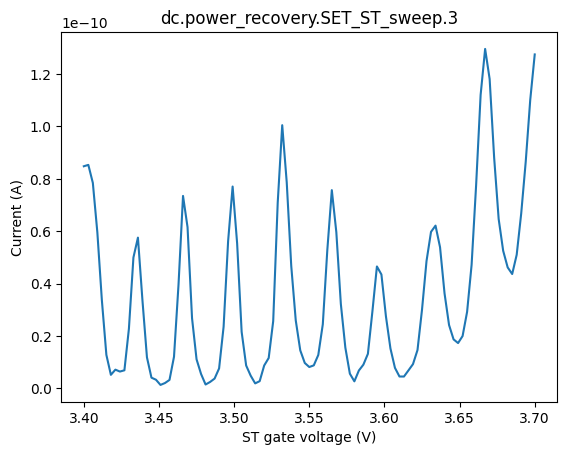

In [479]:
# Get our surroundings

low = 3.4
high = 3.7
pts = 101

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty)  # overlap points so we average

monty.save(result)

### Proccess SET result
To find a good feedback point

[ 81 106 146 172 198]


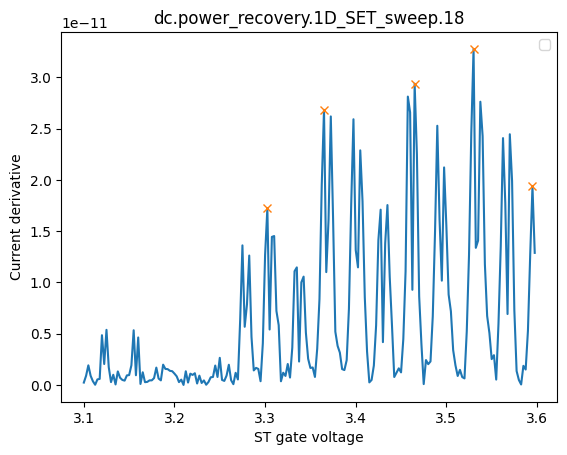

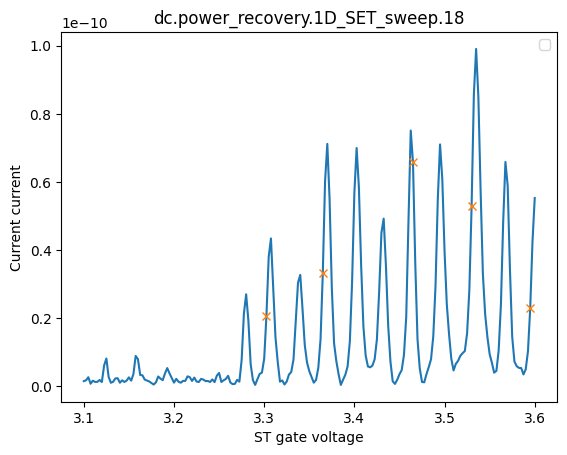

In [194]:
g_range = np.linspace(low, high, pts)
deriv = np.abs(np.diff(result["R"]))
R = result["R"]

peaks, _ = find_peaks(deriv, height=1e-11, distance=20)
#peak = np.argmax(deriv)

fig = plt.figure()
plt.plot(g_range[:-1], deriv)
plt.plot(g_range[peaks], deriv[peaks], "x")
#plt.plot(g_range[peak], deriv[peak], "x")
plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current derivative")
plt.legend()

fig = plt.figure()
plt.plot(g_range, R)
plt.plot(g_range[peaks], R[peaks], "x")
#plt.plot(g_range[peak], deriv[peak], "x")
plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current current")
plt.legend()

print(peaks)

Best peak at inx = 172
Corresponds to ST=3.5300000000000002 and lockin=5.2897453778e-11


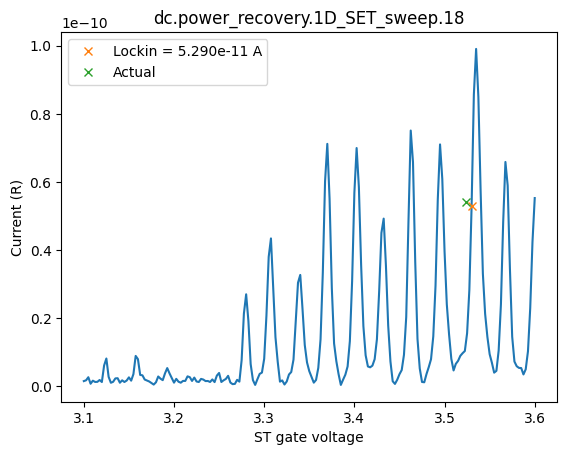

In [201]:
# choose the appropriate peak here
peak = peaks[3]

st_start = g_range[peak]
fix_lockin = result['R'][peak]  # current value to lock in at

print(f"Best peak at inx = {peak}")
print(f"Corresponds to ST={st_start} and lockin={fix_lockin}")

fig = plt.figure()
plt.plot(g_range, result["R"])
plt.plot(g_range[peak], result["R"][peak], "x", label=f"Lockin = {fix_lockin:1.3e} A")

# add where we are now
plt.plot(si.ST(), lockin.R(), "x", label="Actual")

# add our target point
#plt.plot(3.848668, target, "x")

plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current (R)")
plt.legend()

In [286]:
# go to the target
st_start = 3.5

si.ST(st_start)
time.sleep(1)
lockin.R()

#%% Lock in on target

target = 6e-11 #fix_lockin
tol = 0.001e-10

In [289]:
def feedback(gate, lockin, target: float, stepsize=0.001, slope="up"):
    """
    Apply proportional feedback blindly
    """
    if slope == "up":
        sgn = 1
    elif slope == "down":
        sgn = -1
    else:
        raise (f"Unknown slope '{slope}'. Must be either 'up' or 'down'")

    r = lockin.R()
    error = (target - r) * sgn
    adjust = error / target * stepsize  # normalised error func
    g = gate() + adjust  # new gate voltage

    upperbound = 3.6
    lowerbound = 3.4

    if g > upperbound:  # upper bound
        print(f"Aborting feedback: correction voltage exceeds threshold, {g} > {upperbound}. No change to ST.")
    elif g < lowerbound:  # lower bound
        print(f"Aborting feedback: correction voltage fails to meet threshold, {g} < {lowerbound}. No change to ST.")
    #elif np.abs(r-target) > 0.03e-10:  # take a small step if good
    #    print(f"small step {np.abs(r-target)}")
    #    gate(gate() + adjust/4)
    #    time.sleep(0.5)
    else:
        gate(g)
        time.sleep(0.5)

def gettotarget():  # inherit global variables (bad!!!!)
    print(f"Target = {target:.4e}, tol = {tol}, initial ST = {si.ST()}")
    while np.abs(lockin.R()-target) > tol:
        feedback(si.ST, lockin, target, stepsize=0.001, slope="up")
        print(f"\rST = {si.ST():.4e}, lockin = {lockin.R():.4e}, delta = {np.abs(lockin.R()-target):.4e}", end="")
        time.sleep(0.1)
    print(f"\nFinal ST = {si.ST()}")

In [164]:
si.ST(3.23)

In [200]:
gettotarget()

Target = 5.2897e-11, tol = 1e-13, initial ST = 3.530003
ST = 3.5241e+00, lockin = 5.4099e-11, delta = 1.1307e-12
Final ST = 3.524118


## Load/Unload dot methods

In [261]:
# flush dots 
#dots.flushdots(si, low=1.0, high=1.9)

low = 1.0
high = 1.75

tic = time.time()
si.P1(low)
si.P2(low)
print(f"Flushed out to {low}V, raising to {high}V")
time.sleep(0.5)
si.P1(high)
si.P2(high)
print(f"Done. Took {time.time()-tic} seconds.")

Flushed out to 1.0V, raising to 1.75V
Done. Took 59.56040978431702 seconds.


In [235]:
# set P1/P2 load values
si.P1(1.65)
si.P2(1.65)

In [262]:
# load dots
#dots.loaddots(si, high=1.2)

thresh = 1.2

tic = time.time()
si.SETB(thresh)
time.sleep(0.5)
si.SETB(0)
print(f"Done. Took {time.time()-tic} seconds.")

Done. Took 47.71217083930969 seconds.


# Sweeps
## P1 scan 1D

In [314]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 1.749996
P2 = 1.749995
ST = 3.799998


In [317]:
si.ST(3.53)  # when doing a downwards sweep slightly undershoot the target point.

In [318]:
gettotarget()

Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530003
ST = 3.5379e+00, lockin = 6.0059e-11, delta = 2.8875e-14
Final ST = 3.537872


Started new run P1_scan.35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:52<00:00,  1.17s/it]


Run finished and took 0:04:54.894757.
Saving to P1_scan.35.xz
Saving to experiment.yaml


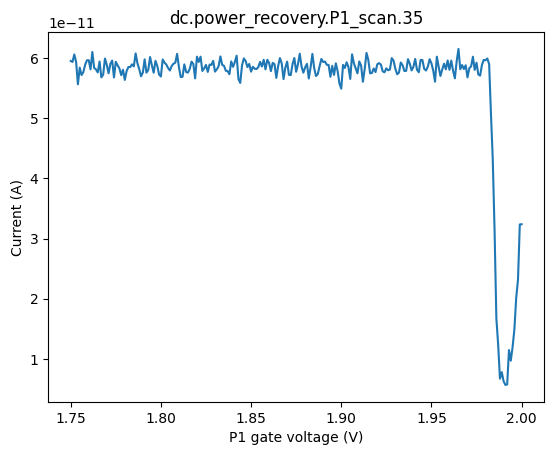

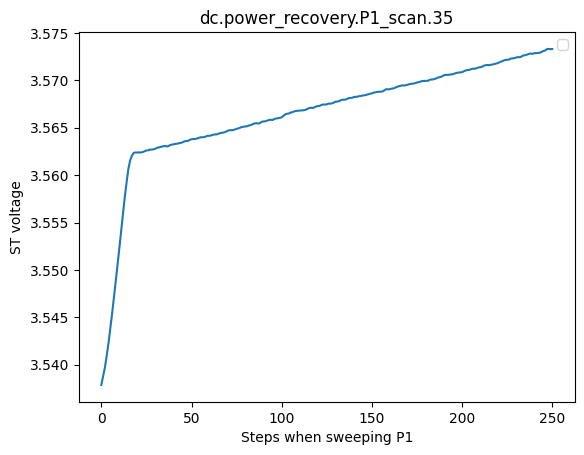

In [320]:
up = False

if up:
    low = 1.75
    high = 2.0
else:
    low = 2.0
    high = 1.75

stepsize = 20e-4
points = 251
gate = si.P1

parameters = {
    "desc": f"1D sweep of P1 (with feedback techniques). Stepsize = {stepsize}",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin)",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    "P1": f"Ranged from {low}V -> {high}V in {points} points",
    "P2": f"Fixed at {si.P2()}V",
    "temp": f"Mixing chamber {fridge.temp()} K"
    }

monty.newrun("P1 scan", parameters)

#gettotarget()
#time.sleep(2)

# don't use swiper to make modifying the feedback easier

gate_range = np.linspace(low, high, points)
X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)
delta_I = np.zeros(points)

#fittedfeedback()

# Move to the start and wait a second for the lockin to catchup
# gate(gate_range[0])
# time.sleep(2.0)
# gettotarget()  # get within tolerance now

with tqdm(total=points) as pbar, LivePlot(gate_range, xlabel="P1 gate voltage (V)", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_range):
        gate(g)
        
        time.sleep(0.5)
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        pbar.update(1)
        lplot.update(R)
        
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")


swiper.plotsweep1d(gate_range, R, gate.name, monty)
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift, 'ST_I': delta_I})

# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
# plt.plot(delta_I)
plt.xlabel("Steps when sweeping P1")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

In [189]:
si.ST(3.36)

In [ ]:
# Plot ST history over time
fig = plt.figure()
# plt.plot(ST_drift)
plt.plot(delta_I)
# plt.xlabel("Steps when sweeping P1")
# plt.title(monty.identifier + "." + monty.runname)
# plt.ylabel("ST voltage")
# plt.legend()
# monty.savefig(plt, "ST history")

## Detuning scan

In [458]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 1.650001
P2 = 1.650001
ST = 3.532999


In [459]:
si.P2(1.9)
si.P1(1.65)
gb_control_si.VICL(3.4)

In [460]:
#si.ST(3.52)
gettotarget()

Target = 6.0000e-11, tol = 1e-12, initial ST = 3.532999
ST = 3.5259e+00, lockin = 5.9970e-11, delta = 4.6305e-14
Final ST = 3.525867


Started new run detuning_scan.36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [05:56<00:00,  1.18s/it]


Run finished and took 0:05:56.531707.
Saving to detuning_scan.36.xz
Saving to experiment.yaml


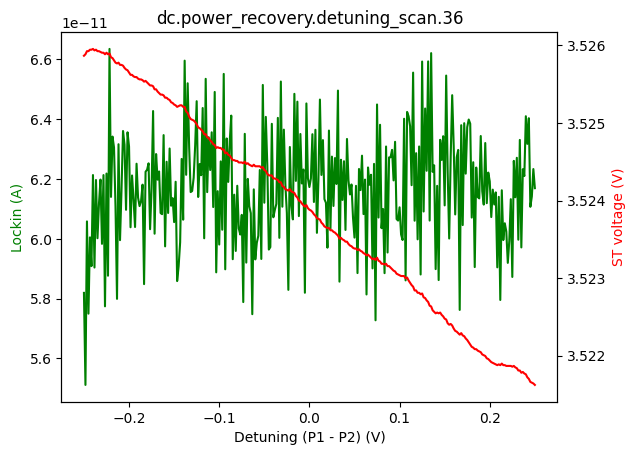

In [461]:
low = 1.65
high = 1.9
points = 301
stepsize = 5e-4

# choose which gates are going up/down
forward = True
if forward:
    gateup = si.P1
    gatedown = si.P2
else:
    gateup = si.P2
    gatedown = si.P1

parameters = {
    "desc": "Sweep detuning axis (P1 - P2) (feedback)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    gateup.name: f"Ranged from {low}V -> {high}V in {points} points",  # P1 or P2
    gatedown.name: f"Ranged from {high}V -> {low}V in {points} points",  # P1 or P2
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

monty.newrun("detuning scan", parameters)

# gate voltage
gate_up_range = np.linspace(low, high, points)
gate_down_range = np.linspace(high, low, points)

# Create detuning axis
detuning = np.linspace(low-high, high-low, points)
if not forward:  # reverse as the data is collected backwards
    detuning = detuning[::-1]

X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)

with tqdm(total=points) as pbar, LivePlot(detuning, xlabel="Detuning", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_up_range):
        gateup(g)
        gatedown(gate_down_range[j])
        time.sleep(0.5)
        
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        
        pbar.update(1)
        lplot.update(R)
        
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")


#swiper.plotsweep1d(gate_range, R, gate.name, monty)
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})

# Plot everything
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()

ax0.plot(detuning, R, "g-", label="Lockin")
ax0.set_ylabel("Lockin (A)", color="g")

# Plot ST history over time
ax1.plot(detuning, ST_drift, "r-", label="ST gate")
ax1.set_ylabel("ST voltage (V)", color="r")

ax0.set_xlabel(f"Detuning ({gateup.name} - {gatedown.name}) (V)")
ax0.set_title(monty.identifier + "." + monty.runname)

monty.savefig(plt, "detuning")

In [433]:
si.ST()

3.535986

## Charge stability diagram

In [ ]:
# gate 1 stepped over slowly
gate1 = si.P2
low1 = 1.75
high1 = 2.1
points1 = 200

# gate 2 swept frequently
gate2 = si.P1
low2 = 1.75
high2 = 2.1
points2 = 200

stepsize = 12e-4

parameters = {
    "desc": "Sweep both P1 and P2 with feedback present.",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize of {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    gate1.name: f"Ranged from {low1}V -> {high1}V in {points1} points",
    gate2.name: f"Ranged from {low2}V -> {high2}V in {points2} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }


monty.newrun("p1 vs p2", parameters)

G1_range = np.linspace(low1, high1, points1)
G2_range = np.linspace(low2, high2, points2)

X = np.zeros((points1, points2))
Y = np.zeros((points1, points2))
R = np.zeros((points1, points2))
P = np.zeros((points1, points2))
ST_drift = np.zeros(points1*points2)
delta_I = np.zeros(points1*points2)


with tqdm(total=points1*points2) as pbar, LiveContourPlot(G2_range, G1_range, xlabel=f"{gate2.name} voltage", ylabel=f"{gate1.name} voltage") as lplot:
    for (j, g1) in enumerate(G1_range):
        gate1(g1)
        time.sleep(0.3)
        #gettotarget()
        time.sleep(1)
        
        for (i, g2) in enumerate(G2_range):
            gate2(g2)
            time.sleep(0.3)
            
            ST_drift[j*points2+i] = si.ST()
            X[j, i] = lockin.X()
            Y[j, i] = lockin.Y()
            R[j, i] = lockin.R()
            P[j, i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
            #delta_I[j*points2+i] = fittedfeedback()
            
        # Flip the direction of the next sweep
        monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}) #, "ST_T": delta_I})
        G2_range = G2_range[::-1]
        

swiper.plotsweep2d(G1_range, G2_range, R, gate1.name, gate2.name, monty)  # note wont separate directions
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift, "ST_T": delta_I})


# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
plt.xlabel("Steps when sweeping P1/P2")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

# Split the 2D sweep into forwad and backward plots

plt.figure()
plt.pcolormesh(G2_range, G1_range[::2], R[::2, :], shading="nearest")  
plt.colorbar()
plt.ylabel(f"{gate1.name} voltage (V)")
plt.xlabel(f"{gate2.name} voltage (V)")
plt.title(monty.identifier + "." + monty.runname + "_forward")
monty.savefig(plt, "stability forward")

plt.figure()
plt.pcolormesh(G2_range, G1_range[1::2], R[1::2, ::-1], shading="nearest")  
plt.colorbar()
plt.ylabel(f"{gate1.name} voltage (V)")
plt.xlabel(f"{gate2.name} voltage (V)")
plt.title(monty.identifier + "." + monty.runname + "_back")
monty.savefig(plt, "stability backward")

## Detuning scan vs J (2D)

In [477]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 1.700003
P2 = 1.900001
ST = 3.523175


In [473]:
si.P1(1.7)

In [476]:
si.ST(3.53)
gettotarget()

Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530003
ST = 3.5232e+00, lockin = 6.1357e-11, delta = 1.3012e-12
Final ST = 3.523175


Started new run detuning_vs_J


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2211/2211 [36:42<00:00,  1.00it/s]


Run finished and took 0:36:42.976293.
Saving to detuning_vs_J.xz
Saving to experiment.yaml


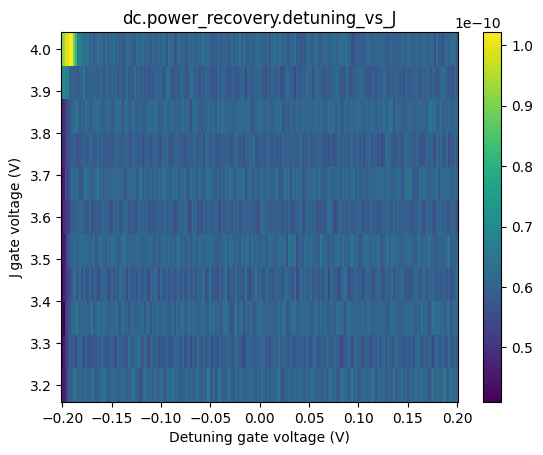

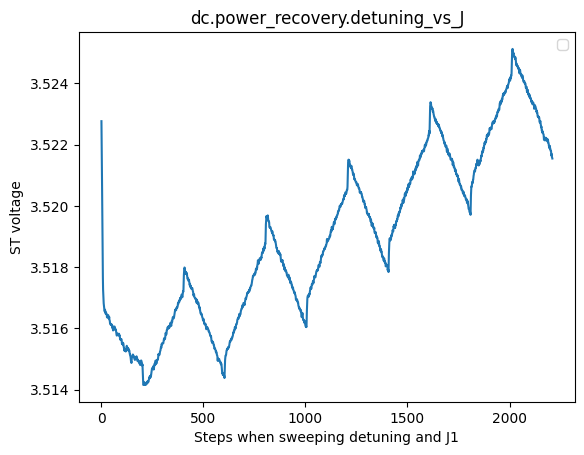

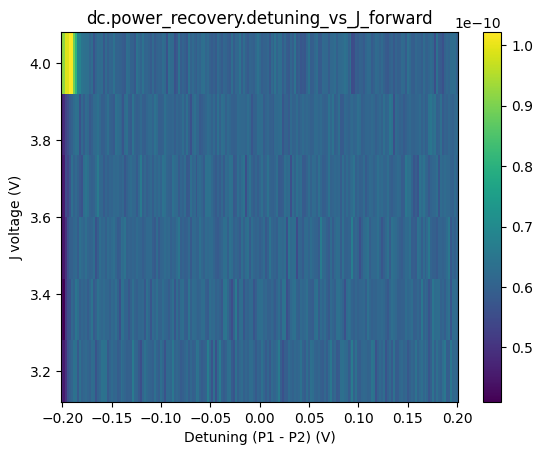

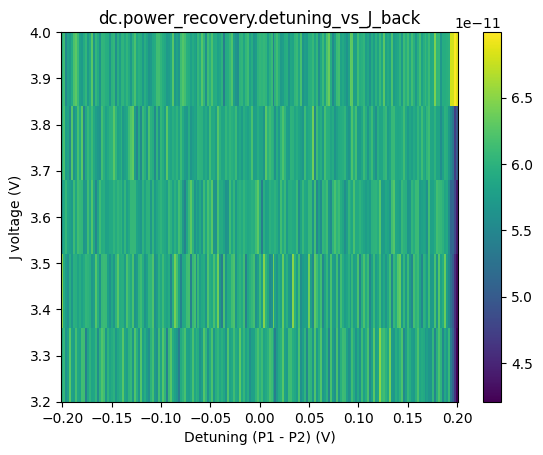

In [478]:
# Setup P1 / P2  detuning params
lowp = 1.7
highp = 1.9
pointsp = 201

# choose which gates are going up/down
forward = True
if forward:
    gateup = si.P1
    gatedown = si.P2
else:
    gateup = si.P2
    gatedown = si.P1

stepsize = 12e-4

# Setup J1 (VICL) (swept slowly)
lowj = 4.0
highj = 3.2
pointsj = 11
gatej = gb_control_si.VICL

parameters = {
    "desc": f"Sweep detuning axis ({gateup.name} - {gatedown.name}) against J1 (VICL)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Start at {si.ST()}V (target of {target} on lockin with stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    gateup.name: f"Ranged from {lowp}V -> {highp}V in {pointsp} points",  # P1 or P2
    gatedown.name: f"Ranged from {highp}V -> {lowp}V in {pointsp} points",  # P1 or P2
    "J1": f"Ranged from {lowj}V -> {highj}V in {pointsj} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

monty.newrun("detuning vs J", parameters)

# gate voltages
gate_up_range = np.linspace(lowp, highp, pointsp)
gate_down_range = np.linspace(highp, lowp, pointsp)
j_range = np.linspace(lowj, highj, pointsj)

# Create detuning axis
detuning = np.linspace(lowp-highp, highp-lowp, pointsp)
if not forward:  # reverse as the data is collected backwards (initially)
    detuning = detuning[::-1]

X = np.zeros((pointsj, pointsp))
Y = np.zeros((pointsj, pointsp))
R = np.zeros((pointsj, pointsp))
P = np.zeros((pointsj, pointsp))
ST_drift = np.zeros(pointsj*pointsp)

with tqdm(total=pointsj*pointsp) as pbar, LiveContourPlot(detuning, j_range, xlabel=f"Detuning ({gateup.name} - {gatedown.name}) (V)", ylabel="J gate voltage") as lplot:
    for (j, gj) in enumerate(j_range):
        gatej(gj)  # J1
        time.sleep(0.3)
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
        #gettotarget()  # perhaps be even more agressive on the start of each sweep?
        time.sleep(1)
        
        for (i, g) in enumerate(gate_up_range):
            gateup(g)
            gatedown(gate_down_range[i])
            time.sleep(0.3)
            
            ST_drift[j*pointsp+i] = si.ST()
            X[j, i] = lockin.X()
            Y[j, i] = lockin.Y()
            R[j, i] = lockin.R()
            P[j, i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
            
        monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})
        
        # Flip the direction of the next sweep
        gate_up_range = gate_up_range[::-1]
        gate_down_range = gate_down_range[::-1]

monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}) 


swiper.plotsweep2d(j_range, detuning, R, "J", "Detuning", monty)  # note wont separate directions

# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
plt.xlabel("Steps when sweeping detuning and J1")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

# Split the 2D sweep into forwad and backward plots

plt.figure()
plt.pcolormesh(detuning, j_range[::2], R[::2, :], shading="nearest")
plt.colorbar()
plt.ylabel("J voltage (V)")
plt.xlabel(f"Detuning ({gateup.name} - {gatedown.name}) (V)")
plt.title(monty.identifier + "." + monty.runname + "_forward")
monty.savefig(plt, "stability forward")

plt.figure()
plt.pcolormesh(detuning, j_range[1::2], R[1::2, ::-1], shading="nearest")
plt.colorbar()
plt.ylabel("J voltage (V)")
plt.xlabel(f"Detuning ({gateup.name} - {gatedown.name}) (V)")
plt.title(monty.identifier + "." + monty.runname + "_back")
monty.savefig(plt, "stability backward")





# Load and parameter sweep
Sweep the parameter space of loading/unloading electrons and viewing P1 sweeps

In [480]:
def reload(thresh=1.1, p=1.75, j=3.5):
    """
    p = where to raise P1 and P2 to after flushing before reloading
    """
    low = 1.0
    tic = time.time()

    print("Flushing electrons...")
    si.P1(low)
    si.P2(low)
    time.sleep(0.5)

    print("Raising P1 and P2...")
    si.P1(p)
    si.P2(p)
    gb_control_si.VICL(j)

    print("Loading electrons...")
    si.SETB(thresh)
    time.sleep(0.5)
    si.SETB(0)
    print(f"Reloaded in {time.time()-tic} seconds.")

In [485]:
def scan_p1(low=1.75, high=2.0, points=301, gate=si.P1, params=""):
    parameters = {
        "desc": f"Parameter sweep. Loaded electrons with {params}",
        "lockin_amplitude": "Set to 10uV",
        "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin)",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "SETB": f"Fixed at {si.SETB()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V",
        "P1": f"Ranged from {low}V -> {high}V in {points} points",
        "P2": f"Fixed at {si.P2()}V",
        "temp": f"Mixing chamber {fridge.temp()} K"
        }
    
    monty.newrun(f"P_{params}", parameters)
    
    gate_range = np.linspace(low, high, points)
    X = np.zeros((points))
    Y = np.zeros((points))
    R = np.zeros((points))
    P = np.zeros((points))
    
    with tqdm(total=points) as pbar, LivePlot(gate_range, xlabel="P1 gate voltage (V)", ylabel="Current (A)") as lplot:
        for (j, g) in enumerate(gate_range):
            gate(g)
            
            time.sleep(0.5)
            ST_drift[j] = si.ST()
            X[j] = lockin.X()
            Y[j] = lockin.Y()
            R[j] = lockin.R()
            P[j] = lockin.P()
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=5e-11, slope="up")
    
    
    swiper.plotsweep1d(gate_range, R, gate.name, monty)
    monty.save({"X": X, "Y": Y, "R": R, "P": P})

In [489]:
load_setb = np.arange(0.8, 1.3, 0.05)
load_p1p2 = np.arange(1.6, 1.9, 0.1)
load_j = np.arange(3.0, 4.0, 0.2)

In [490]:
len(load_setb) * len(load_p1p2) * len(load_j) * 8/60

20.0

In [488]:
tol=1e-12

In [ ]:
for p1p2 in load_p1p2:
    for setb in load_setb:
        for j in load_j:
            name = f"SETB{setb} P{p1p2} J{j}"
            print(f"Starting new run: {name}")
            reload(thresh=setb, p=p1p2, j=j)
            gettotarget()
            scan_p1(low=1.75, high=2.1, points=401, params=f"up {name}")
            scan_p1(low=2.1, high=1.75, points=401, params=f"down {name}")

Starting new run: SETB0.8 P1.6 J3.0
Flushing electrons...


In [306]:
tol

1e-12

In [308]:
monty.identifier

'dc.recovery'

In [323]:
?si.P1.

Signature: si.P1.soft_ramp(rate=None, step=None)
Docstring:
Set up a software ramp on the voltage parameter, saving the previous values
of step/delay if available
File:      c:\users\ld2007\documents\si_cmos_james\quench\libraries\qcodes_measurements\device\gate.py
Type:      method

# Push electrons out
Sweep both P1 and P2 down after loading to see electrons transition out of the dot. Use feedback

In [482]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 1.900002
P2 = 1.700003
ST = 3.700005


In [469]:
reload(thresh=1.1, p=1.65, j=3.5)  # WORKING LOAD=1.1,1.65,3.5

Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 74.11827421188354 seconds.


In [483]:
si.ST(3.52)

In [491]:
gettotarget()
lockin.R()

Target = 6.0000e-11, tol = 1e-12, initial ST = 3.521338

Final ST = 3.521338


5.9892285575e-11

In [463]:
si.P2(1.9)

Started new run kickout_scan.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [05:56<00:00,  1.19s/it]


Run finished and took 0:05:56.837308.
Saving to kickout_scan.1.xz
Saving to experiment.yaml


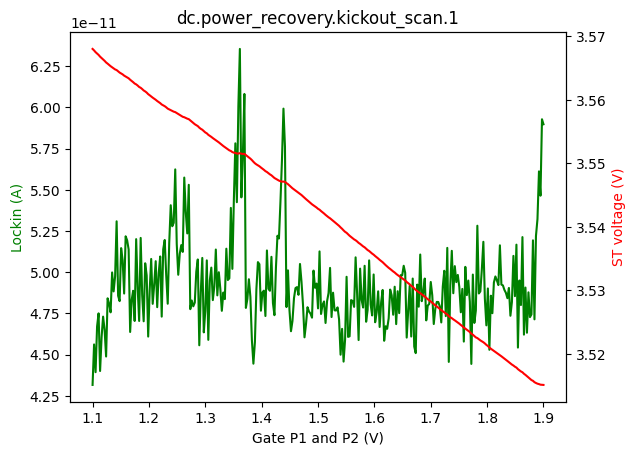

In [468]:
start = 1.9
end = 1.1
points = 301
stepsize = 10e-4

parameters = {
    "desc": "Sweep P1 and P2 down to remove electrons (feedback)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    "P1": f"Ranged from {start}V -> {end}V in {points} points",
    "P2": f"Ranged from {start}V -> {end}V in {points} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

monty.newrun("kickout scan", parameters)

# gate voltage
gate_range = np.linspace(start, end, points)

X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)

with tqdm(total=points) as pbar, LivePlot(gate_range, xlabel="Gate voltage (P1 and P2) (V)", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_range):
        si.P1(g)
        si.P2(g)
        time.sleep(0.5)
        
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        
        pbar.update(1)
        lplot.update(R)
        
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")


monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})


# Plot everything
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()

ax0.plot(gate_range, R, "g-", label="Lockin")
ax0.set_ylabel("Lockin (A)", color="g")

# Plot ST history over time
ax1.plot(gate_range, ST_drift, "r-", label="ST gate")
ax1.set_ylabel("ST voltage (V)", color="r")

ax0.set_xlabel("Gate P1 and P2 (V)")
ax0.set_title(monty.identifier + "." + monty.runname)

monty.savefig(plt, "kickout")